# **Deteksi Outlier dengan K-Nearest Neighbors (KNN) dalam Data Understanding**


## Apa sih Outlier itu ?  
**Outlier** adalah data yang memiliki nilai yang sangat berbeda dari data lainnya dalam suatu dataset. Deteksi outlier penting dalam tahap Data Understanding karena dapat membantu mengidentifikasi anomali yang mungkin merupakan kesalahan pengukuran, data yang tidak relevan, atau informasi penting dalam analisis lebih lanjut.
## Konsep Deteksi Outlier dengan k-NN
**k-Nearest Neighbors (k-NN)** adalah metode berbasis jarak yang dapat digunakan untuk mendeteksi outlier. Prinsip utamanya adalah menghitung jarak antara suatu titik data dengan k tetangga terdekatnya. Jika suatu titik memiliki jarak rata-rata yang jauh dibandingkan dengan data lainnya, maka kemungkinan besar titik tersebut adalah outlier.
## Langkah-langkah Deteksi Outlier dengan k-NN
1. Tentukan jumlah tetangga terdekat (k): Pilih nilai k yang sesuai (biasanya berdasarkan eksperimen).
2. Hitung jarak antara setiap titik data dengan k tetangga terdekatnya: Gunakan metrik jarak seperti Euclidean Distance atau Manhattan Distance.
3. Tentukan skor outlier:
  - Salah satu pendekatan yang umum adalah k-NN Distance, yaitu rata-rata jarak suatu titik ke k tetangga terdekatnya.
  - Alternatif lain adalah menggunakan Local Outlier Factor (LOF), yang membandingkan kepadatan lokal suatu titik dengan kepadatan tetangganya.
4. Identifikasi outlier:
Jika skor outlier lebih tinggi dari ambang batas yang ditentukan, maka titik tersebut dianggap sebagai outlier.


## Kesimpulan
Metode k-NN sangat berguna dalam deteksi outlier karena berbasis jarak dan tidak memerlukan asumsi distribusi data. Namun, pemilihan parameter k sangat berpengaruh terhadap hasil deteksi. Pendekatan ini banyak digunakan dalam analisis data, terutama dalam Data Understanding sebelum melakukan pemodelan lebih lanjut.




In [1]:
%pip install pymysql
%pip install psycopg2


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Perintah %pip install pymysql dan %pip install psycopg2 digunakan untuk menginstal dua pustaka Python yang berkaitan dengan database:

pymysql → Digunakan untuk berkomunikasi dengan database MySQL menggunakan konektor berbasis Python.

psycopg2 → Digunakan untuk berkomunikasi dengan database PostgreSQL.

 id           class  petal length  petal width  sepal length  sepal width  knn_distance  outlier_knn
  1     Iris-setosa           1.4          0.2           5.1          3.5      0.141421        False
  2     Iris-setosa          14.0          2.0          40.9         30.0     43.517123         True
  3     Iris-setosa           1.3          0.2           4.7          3.2      0.264575        False
  4     Iris-setosa           1.5          0.2           4.6          3.1      0.244949        False
  5     Iris-setosa           1.4          0.2           5.0          3.6      0.223607        False
  6     Iris-setosa           1.7          0.4           5.4          3.9      0.374166        False
  7     Iris-setosa           1.4          0.3           4.6          3.4      0.316228        False
  8     Iris-setosa           1.5          0.2           5.0          3.4      0.200000        False
  9     Iris-setosa           1.4          0.2           4.4          2.9      0.346410    

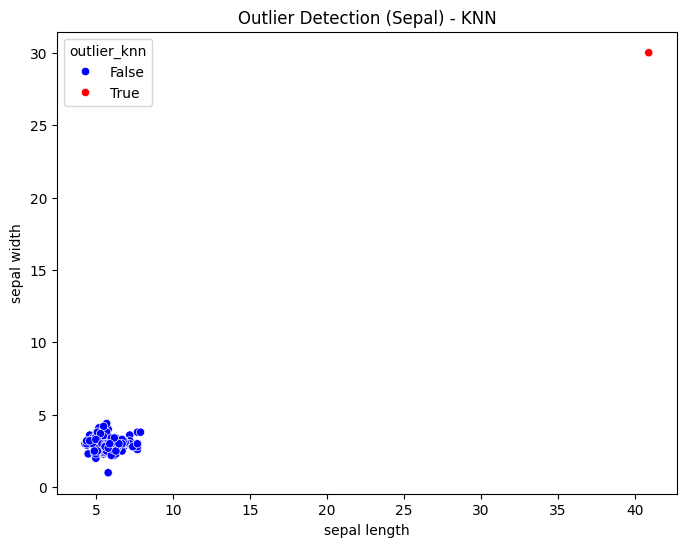

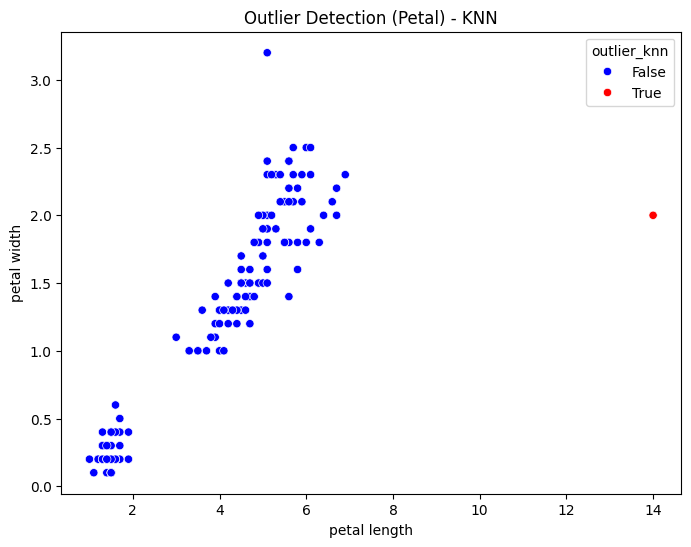

In [3]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def get_pg_data():
    conn = psycopg2.connect(
        host="pg-3c7b065e-callistanovia6-e714.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_YS6MQk-gcL_QYbbL0BE",
        database="defaultdb",
        port=13412
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM irispostgre.postgree")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-2785e5b5-mysqllpendata.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_4dn925PyLTml8yy9MYL",
        database="irissql",
        port=10657
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM flowers")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id'
df_merged = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik
feature_columns = ["petal length", "petal width", "sepal length", "sepal width"]
data_values = df_merged[feature_columns].values

# KNN Outlier Detection
def knn_outlier_detection(data, k=5):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    avg_distances = distances[:, -1]  # Ambil jarak k-terjauh sebagai skor
    return avg_distances

# Hitung K-NN distance
df_merged["knn_distance"] = knn_outlier_detection(data_values, k=5)

# Tentukan threshold sebagai nilai rata-rata + 2 standar deviasi
threshold = df_merged["knn_distance"].mean() + 2 * df_merged["knn_distance"].std()
df_merged["outlier_knn"] = df_merged["knn_distance"] > threshold

# Cetak hasil
df_result = df_merged[["id", "class", "petal length", "petal width", "sepal length", "sepal width", "knn_distance", "outlier_knn"]]
print(df_result.to_string(index=False))
num_outliers = df_merged["outlier_knn"].sum()
print(f"\nJumlah outlier: {num_outliers}")

# Cetak data outlier
outliers = df_merged[df_merged["outlier_knn"]]
print("\nData Outlier:")
print(outliers.to_string(index=False))

# Visualisasi outlier berdasarkan K-NN
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_merged["sepal length"], y=df_merged["sepal width"],
    hue=df_merged["outlier_knn"], palette={False: "blue", True: "red"}
)
plt.title("Outlier Detection (Sepal) - KNN")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_merged["petal length"], y=df_merged["petal width"],
    hue=df_merged["outlier_knn"], palette={False: "blue", True: "red"}
)
plt.title("Outlier Detection (Petal) - KNN")
plt.show()

Kode diatas untuk  mendeteksi outlier menggunakan K-Nearest Neighbors (KNN) pada data dari PostgreSQL dan MySQL. Data dari kedua sumber digabung berdasarkan 'id' dan 'class', lalu fitur numerik seperti panjang & lebar petal/sepal diekstrak untuk analisis.

Metode KNN mendeteksi outlier dengan menghitung jarak ke 5 tetangga terdekat (k=5). Jarak terjauh dari kelima tetangga digunakan sebagai skor outlier. Ambang batas ditentukan dari rata-rata skor + 2 standar deviasi—data dengan skor melebihi threshold dianggap outlier.

Hasil deteksi ditambahkan ke dalam dataframe sebagai label outlier (True/False). Visualisasi scatter plot menampilkan outlier dalam warna merah, sementara data normal berwarna biru. Kode ini juga mencetak jumlah serta detail data outlier yang ditemukan.

## **Memisahkan outlier dari data**

In [4]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

def get_pg_data():
    conn = psycopg2.connect(
        host="pg-289a0f88-pendataa.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_1tT_bnHq81keqZ9n-wh",
        database="defaultdb",
        port=22825
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM iris_postgresql")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

def get_mysql_data():
    conn = pymysql.connect(
        host="mysql-9b686fb-pendataa.g.aivencloud.com",
        user="avnadmin",
        password="AVNS_ZuFdVS1OQkmHx4P1Wtp",
        database="defaultdb",
        port=22825
    )
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM irismysql")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(data, columns=columns)

# Ambil data dari kedua database
df_postgresql = get_pg_data()
df_mysql = get_mysql_data()

# Gabungkan berdasarkan kolom 'id' dan 'class'
df_merge = pd.merge(df_mysql, df_postgresql, on=["id", "class"], how="inner")

# Ambil data fitur numerik tanpa kolom 'class'
feature_columns = ["petal_length", "petal_width", "sepal_length", "sepal_width"]
data_values = df_merge[feature_columns].values

# Inisialisasi model LOF
clf = LocalOutlierFactor(n_neighbors=90)
label = clf.fit_predict(data_values)

# Tambahkan hasil label ke dataframe
df_merge["outlier_label"] = label

# Cetak hasil dengan ID dan class
print(df_merge.to_string(index=False))

num_outliers = (label == -1).sum()
print(f"\nJumlah outlier: {num_outliers}")
df_filtered = df_merge[label == 1].drop(columns=["outlier_label"], errors='ignore')
outliers = df_merge[label == -1].drop(columns=["outlier_label"], errors='ignore')
print("\nData Outlier:")
print(outliers.to_string(index=False))
print("\nJumlah data setelah dihapus : ",len(df_filtered))
print("\nData tidak outlier :")
print(df_filtered.to_string(index=False))

 id           class  petal_length  petal_width  sepal_length  sepal_width  outlier_label
  1     Iris-setosa          14.0          2.0          50.1         30.5             -1
  2     Iris-setosa          14.0          2.0          40.9         30.0             -1
  3     Iris-setosa          13.0          2.0          40.7         30.2             -1
  4     Iris-setosa          15.0          2.0          40.6         30.1             -1
  5     Iris-setosa          14.0          2.0          50.0         30.6             -1
  6     Iris-setosa           1.7          0.4           5.4          3.9              1
  7     Iris-setosa           1.4          0.3           4.6          3.4              1
  8     Iris-setosa           1.5          0.2           5.0          3.4              1
  9     Iris-setosa           1.4          0.2           4.4          2.9              1
 10     Iris-setosa           1.5          0.1           4.9          3.1              1
 11     Iris-setosa  

Kode diatas bertujuan untuk mengambil data dari dua database (PostgreSQL & MySQL), menggabungkan data, serta mendeteksi dan menghapus outlier menggunakan Local Outlier Factor (LOF).
Dalam mengambil Data dari PostgreSQL & MySQL meliputi :
Data dari tabel iris_postgresql dan irismysql diambil menggunakan koneksi ke database masing-masing.
dan data dikonversi menjadi DataFrame Pandas.
Lalu untu menggabungkan Data meliputi data dari kedua database digabungkan berdasarkan kolom "id" dan "class".
Dalam Deteksi Outlier dengan LOF,
kita Menggunakan fitur numerik (petal_length, petal_width, sepal_length, sepal_width) dan menerapkan Local Outlier Factor (LOF) dengan n_neighbors=90 untuk mendeteksi outlier.
Terakhir yaitu mengelompokkan data yang meliputi
data yang terdeteksi sebagai outlier diberi label -1, data yang dianggap normal diberi label 1, dan data outlier dan non-outlier dipisahkan, kemudian dicetak ke layar.

**KESIMPULAN :**

Kode diatas membantu membersihkan dataset dari outlier sebelum analisis lebih lanjut dengan mengambil, menggabungkan, dan memfilter data secara otomatis.

## **Menghitung Akurasi dari data**

In [5]:
X = df_merge[feature_columns]
y = df_merge["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=90, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merge["outlier"] = outlier_labels

# Pisahkan data dengan outlier dan tanpa outlier
df_cleaned = df_merge[df_merge["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),
    test_size=0.2,
    random_state=42
)

# Pipeline dengan StandardScaler dan KNN
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Latih model pada data dengan outlier
knn_pipeline.fit(X_train_all, y_train_all)
y_pred_all = knn_pipeline.predict(X_test_all)
accuracy_all = accuracy_score(y_test_all, y_pred_all)
print("Akurasi dengan outlier:", accuracy_all)
print(classification_report(y_test_all, y_pred_all, target_names=label_encoder.classes_))

# Latih model pada data tanpa outlier
knn_pipeline.fit(X_train_clean, y_train_clean)
y_pred_clean = knn_pipeline.predict(X_test_clean)
accuracy_clean = accuracy_score(y_test_clean, y_pred_clean)
print("Akurasi tanpa outlier:", accuracy_clean)
print(classification_report(y_test_clean, y_pred_clean, target_names=label_encoder.classes_))

Akurasi dengan outlier: 0.9666666666666667
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      1.00      0.95         9
 Iris-virginica       1.00      0.91      0.95        11

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30

Akurasi tanpa outlier: 0.9259259259259259
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      0.71      0.83         7
 Iris-virginica       0.80      1.00      0.89         8

       accuracy                           0.93        27
      macro avg       0.93      0.90      0.91        27
   weighted avg       0.94      0.93      0.92        27



Kode di atas bertujuan untuk melakukan deteksi outlier, pembersihan data, serta evaluasi model K-Nearest Neighbors (KNN) dengan dan tanpa outlier.
Mempersiapkan Data meliputi memisahkan fitur (X) dan label kelas (y).
Mengonversi label kelas menjadi format numerik dengan LabelEncoder.
Dalam deteksi dan Penghapusan Outlier
Menggunakan Local Outlier Factor (LOF) untuk mendeteksi outlier.
Menghapus data yang terdeteksi sebagai outlier.
Dan membagi Data Training dan Testing Data dibagi menjadi 80% training dan 20% testing untuk dua versi dataset:
Data asli (dengan outlier), data bersih (tanpa outlier).
Dalam pelatihan dan evaluasi Model KNN Menggunakan pipeline dengan StandardScaler dan KNN (k=11).
Melatih dan menguji model pada data dengan outlier serta tanpa outlier.
Membandingkan akurasi dan melihat classification report untuk analisis performa model.

**KESIMPULAN** :

Kode diatas bertujuan untuk menguji apakah menghapus outlier dapat meningkatkan performa KNN classifier, dengan membandingkan akurasi dan metrik evaluasi lainnya

## **Visualisasi data**

Akurasi: 0.9629629629629629
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       1.00      0.86      0.92         7
 Iris-virginica       0.89      1.00      0.94         8

       accuracy                           0.96        27
      macro avg       0.96      0.95      0.95        27
   weighted avg       0.97      0.96      0.96        27



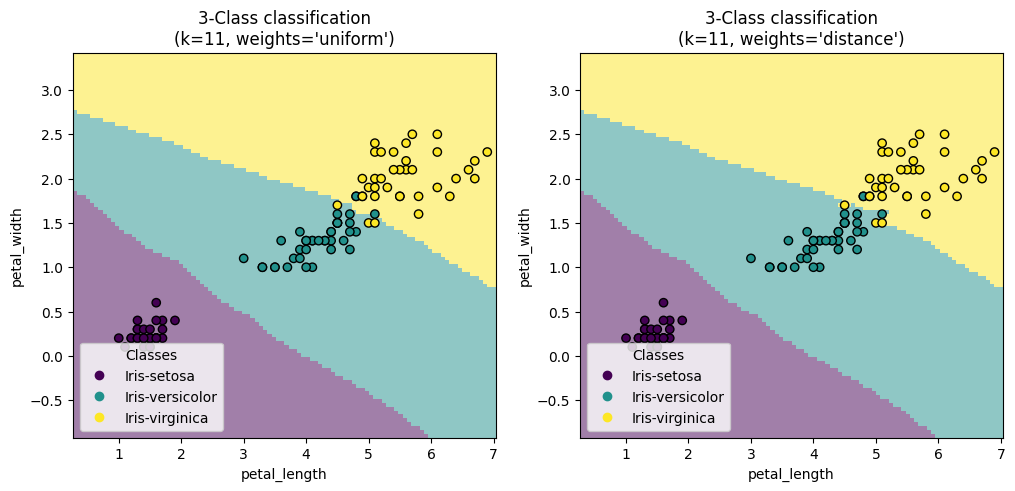

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

# Ambil dua fitur utama untuk visualisasi decision boundary
feature_columns = ["petal_length", "petal_width"]
X = df_cleaned[feature_columns]
y = df_cleaned["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Ubah nama kelas jadi angka

# Membagi data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Pipeline dengan KNN dan StandardScaler
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Pelatihan model KNN
clf.fit(X_train, y_train)

# Evaluasi model
y_pred = clf.predict(X_test)
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualisasi Decision Boundary
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1],
        c=y_train, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

Akurasi: 0.8148148148148148
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       0.62      0.71      0.67         7
 Iris-virginica       0.71      0.62      0.67         8

       accuracy                           0.81        27
      macro avg       0.78      0.78      0.78        27
   weighted avg       0.82      0.81      0.81        27



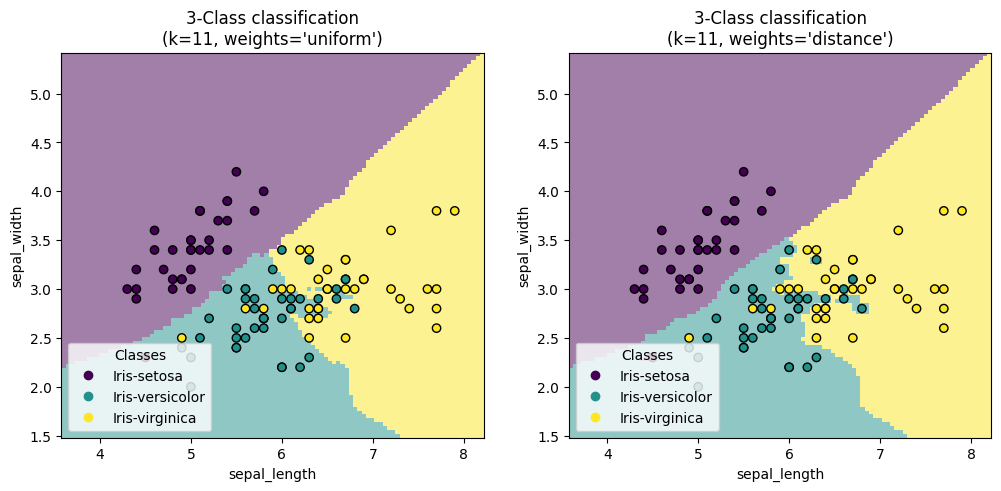

In [8]:
import psycopg2
import pymysql
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay


# Ambil dua fitur utama untuk visualisasi decision boundary
feature_columns = ["sepal_length", "sepal_width"]
X = df_merge[feature_columns]
y = df_merge["class"]

# Encode label kelas ke numerik
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Mengubah nama kelas menjadi angka

# Menerapkan LOF untuk deteksi outlier
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_labels = lof.fit_predict(X)
df_merge["outlier"] = outlier_labels

# Menghapus data yang terdeteksi sebagai outlier
df_cleaned = df_merge[df_merge["outlier"] == 1].drop(columns=["outlier"])

# Membagi data menjadi training (80%) dan testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned[feature_columns],
    label_encoder.transform(df_cleaned["class"]),  # Pastikan target dalam bentuk numerik
    test_size=0.2,
    random_state=42
)

# Pipeline dengan KNN dan StandardScaler
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

# Pelatihan model KNN
clf.fit(X_train, y_train)

# Evaluasi model
y_pred = clf.predict(X_test)
print(f"Akurasi: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Visualisasi Decision Boundary
_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_train, y_train)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_test,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=feature_columns[0],
        ylabel=feature_columns[1],
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(
        X_train.iloc[:, 0], X_train.iloc[:, 1],
        c=y_train, edgecolors="k", cmap="viridis"
    )
    disp.ax_.legend(
        scatter.legend_elements()[0],
        label_encoder.classes_,
        loc="lower left",
        title="Classes",
    )
    _ = disp.ax_.set_title(
        f"3-Class classification\n(k={clf[-1].n_neighbors}, weights={weights!r})"
    )

plt.show()

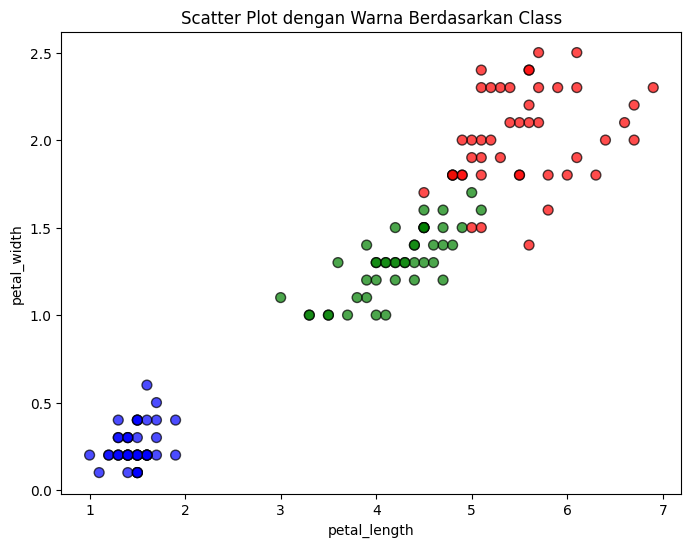

In [9]:
import matplotlib.pyplot as plt

# Pilih dua fitur untuk scatter plot
x_feature = "petal_length"
y_feature = "petal_width"

# Warna berdasarkan kelas
colors = {"Iris-setosa": "blue", "Iris-versicolor": "green", "Iris-virginica": "red"}
df_cleaned["color"] = df_cleaned["class"].map(colors)

# Plot scatter dengan ukuran (s) dan warna (c)
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned[x_feature], df_cleaned[y_feature], s=50, c=df_cleaned["color"], alpha=0.7, edgecolors="k")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Scatter Plot dengan Warna Berdasarkan Class")
plt.show()

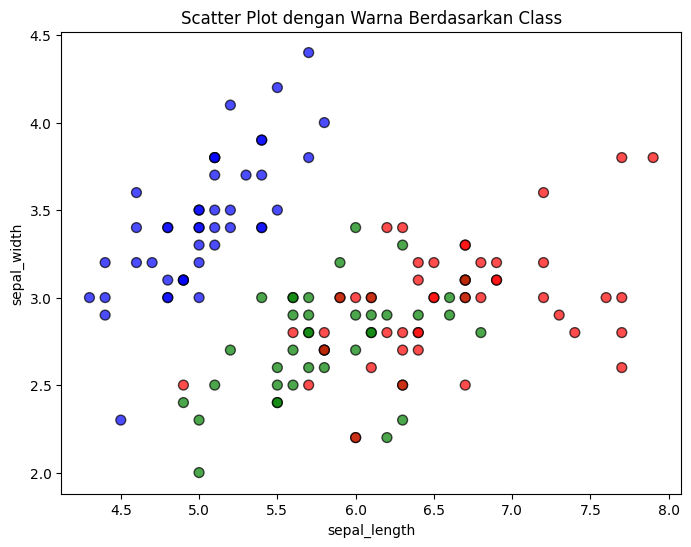

In [10]:
import matplotlib.pyplot as plt

# Pilih dua fitur untuk scatter plot
x_feature = "sepal_length"
y_feature = "sepal_width"

# Warna berdasarkan kelas
colors = {"Iris-setosa": "blue", "Iris-versicolor": "green", "Iris-virginica": "red"}
df_cleaned["color"] = df_cleaned["class"].map(colors)

# Plot scatter dengan ukuran (s) dan warna (c)
plt.figure(figsize=(8, 6))
plt.scatter(df_cleaned[x_feature], df_cleaned[y_feature], s=50, c=df_cleaned["color"], alpha=0.7, edgecolors="k")
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("Scatter Plot dengan Warna Berdasarkan Class")
plt.show()